# Machine Bias
# 
"""
https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm

Context
COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a popular commercial algorithm used by judges
and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). It has been shown that the algorithm
is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (i.e who actually committed
crimes or violent crimes after 2 years). The pattern of mistakes, as measured by precision/sensitivity is notable.

Quoting from ProPublica: 

Black defendants were often predicted to be at a higher risk of recidivism than they actually were. Our analysis found that black defendants
who did not recidivate over a two-year period were nearly twice as likely to be misclassified as higher risk compared to their white counterparts
(45 percent vs. 23 percent). White defendants were often predicted to be less risky than they were. Our analysis found that white defendants who
re-offended within the next two years were mistakenly labeled low risk almost twice as often as black re-offenders (48 percent vs. 28 percent).
The analysis also showed that even when controlling for prior crimes, future recidivism, age, and gender, black defendants were 45 percent more
likely to be assigned higher risk scores than white defendants.

Black defendants were also twice as likely as white defendants to be misclassified as being a higher risk of violent recidivism. And white violent
recidivists were 63 percent more likely to have been misclassified as a low risk of violent recidivism, compared with black violent recidivists.
The violent recidivism analysis also showed that even when controlling for prior crimes, future recidivism, age, and gender, black defendants were
77 percent more likely to be assigned higher risk scores than white defendants. "

Content
Data contains variables used by the COMPAS algorithm in scoring defendants, along with their outcomes within 2 years of the decision, for over
10,000 criminal defendants in Broward County, Florida. 3 subsets of the data are provided, including a subset of only violent
recividism (as opposed to, e.g. being reincarcerated for non violent offenses such as vagrancy or Marijuana).

Indepth analysis by ProPublica can be found in their data methodology article.



Each pretrial defendant received at least three COMPAS scores:  (DisplayText)
“Risk of Recidivism,”
“Risk of Violence” 
“Risk of Failure to Appear.”

COMPAS scores for each defendant ranged from1 to 10, with ten being the highest risk. Scores (ScoreTex)
1 to 4 were labeled by COMPAS as “Low”;
5 to 7 were labeled “Medium”; and
8 to 10 were labeled “High.”


Columns
0 - 4  : 'Person_ID','AssessmentID','Case_ID','Agency_Text', 'LastName',
5 - 9  : 'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text','DateOfBirth',
10 - 14: 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason','Language', 'LegalStatus',
15 - 19: 'CustodyStatus', 'MaritalStatus','Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
20 - 24: 'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
25 - 27: 'AssessmentType', 'IsCompleted', 'IsDeleted'

In [1]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# For preprocessing the data
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
# Standardizing
from sklearn.preprocessing import StandardScaler
# To split the dataset into train and test datasets
from sklearn.model_selection import train_test_split
# To calculate the accuracy score of the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#
from datetime import datetime
from datetime import date
#
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#
import collections


In [2]:
# load dataset
pthfnm = "./compas-scores-raw.csv"
df = pd.read_csv(pthfnm)

In [3]:
# initial EDA
print(df.shape)
print(df.info())

(60843, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60843 entries, 0 to 60842
Data columns (total 28 columns):
Person_ID                  60843 non-null int64
AssessmentID               60843 non-null int64
Case_ID                    60843 non-null int64
Agency_Text                60843 non-null object
LastName                   60843 non-null object
FirstName                  60843 non-null object
MiddleName                 15648 non-null object
Sex_Code_Text              60843 non-null object
Ethnic_Code_Text           60843 non-null object
DateOfBirth                60843 non-null object
ScaleSet_ID                60843 non-null int64
ScaleSet                   60843 non-null object
AssessmentReason           60843 non-null object
Language                   60843 non-null object
LegalStatus                60843 non-null object
CustodyStatus              60843 non-null object
MaritalStatus              60843 non-null object
Screening_Date             60843 non-null object
R

In [4]:
# Review data and Manipulate Data

# Ethnic_Code_Text
print(df.Ethnic_Code_Text.unique())

['Caucasian' 'African-American' 'Hispanic' 'Other' 'Asian' 'African-Am'
 'Native American' 'Oriental' 'Arabic']


In [5]:
# update 'Ethnic_Code_Text' to have conistent values for African Americans
df.loc[df['Ethnic_Code_Text'] == 'African-Am', 'Ethnic_Code_Text'] = 'African-American'
print(pd.value_counts(df['Ethnic_Code_Text']))

African-American    27069
Caucasian           21783
Hispanic             8742
Other                2592
Asian                 324
Native American       219
Arabic                 75
Oriental               39
Name: Ethnic_Code_Text, dtype: int64


In [6]:
# DecileScore should be between 1 & 10, delete otherwise
df.DecileScore.unique()
print((df['DecileScore'] < 1).sum())

45


In [7]:
# remove DecileScore < 1
df = df[df.DecileScore >= 1]
print(pd.value_counts(df['DecileScore']))

1     18465
2      9192
3      8492
4      5338
5      4831
6      4319
7      3338
8      2799
9      2386
10     1638
Name: DecileScore, dtype: int64


In [8]:
# slice and dice

# Slice by 'Ethnic_Code_Text' for blacks & whites
black = df.loc[df['Ethnic_Code_Text'] == 'African-American']
white = df.loc[df['Ethnic_Code_Text'] == 'Caucasian']
joint = df.loc[df['Ethnic_Code_Text'].isin (['Caucasian','African-American'])]
print('black :', black.shape, ' white: ', white.shape, ' joint: ', joint.shape)

black : (27053, 28)  white:  (21765, 28)  joint:  (48818, 28)


In [9]:
# Slice by 'Sex_Code_Text' for males & females
male = df.loc[df['Sex_Code_Text'] == 'Male']
female = df.loc[df['Sex_Code_Text'] == 'Female']
print('male :', male.shape, ' female: ', female.shape)

male : (47479, 28)  female:  (13319, 28)


In [10]:
# Slice by 'DisplayText' for Risk
RiskAppear = df.loc[df['DisplayText'] == 'Risk of Failure to Appear']
RiskViolence = df.loc[df['DisplayText'] == 'Risk of Violence']
RiskRecidivism = df.loc[df['DisplayText'] == 'Risk of Recidivism']
print('Appear:', RiskAppear.shape, ' Violence: ', RiskViolence.shape,  ' Recidivism:',RiskRecidivism.shape)

Appear: (20281, 28)  Violence:  (20272, 28)  Recidivism: (20245, 28)


In [11]:
# Aggregate
grprace = df.groupby(['Ethnic_Code_Text']).count()
grpgender = df.groupby(['Sex_Code_Text']).count()
print('Race: ',grprace.shape, ' Gender:', grpgender.shape)

Race:  (8, 27)  Gender: (2, 27)


# EDA  - looking at potential bias



In [12]:
## Display distribution of group data
# % data distribution by Ethnic_Code_Text
round(grprace[['DecileScore']]/len(df),4)*100

,DecileScore
Ethnic_Code_Text,
African-American,44.50
Arabic,0.12
Asian,0.53
Caucasian,35.80
Hispanic,14.36
Native American,0.36
Oriental,0.06
Other,4.26


In [ ]:
# There are more African Americans (45%) in the dataset, eventhough in the county African American only make 
# up (30%) of the population

In [13]:
# % data distribution by Sex_Code_Text
round(grpgender[['DecileScore']]/len(df),4)*100


,DecileScore
Sex_Code_Text,
Female,21.91
Male,78.09


In [ ]:
# There are more males (78%) in the dataset, eventhough in the county males make 
# up (49%) of the population

In [14]:
# DecileScore Mean by race
race=df.Ethnic_Code_Text.unique()
print('Mean DecileScore by Race')
for i in race:
    mn = round(df.loc[df['Ethnic_Code_Text'] == i]['DecileScore'].mean(), 2)
    print(i,'- ',mn)

Mean DecileScore by Race
Caucasian -  3.11
African-American -  4.29
Hispanic -  2.86
Other -  2.51
Asian -  2.37
Native American -  4.05
Oriental -  2.74
Arabic -  3.13


In [ ]:
# Mean DecileScore is highest for African Americans

In [15]:
# DecileScore Mean by gender
gender=df.Sex_Code_Text.unique()
print('Mean DecileScore by Gender')
for i in gender:
    mn = round(df.loc[df['Sex_Code_Text'] == i]['DecileScore'].mean(), 2)
    print(i,'- ',mn)

Mean DecileScore by Gender
Male -  3.66
Female -  3.26


In [ ]:
# Mean DecileScore is highest for males

In [ ]:
# Visualize

In [16]:
# Define grp_plot_compare:
# creates groups and then plot them to compare them
def grp_plot_compare(df1, df2, xlabel1, colnm1, total_pop, multby, title,label1, label2):
    grp1 = df1.groupby([xlabel1]).count()
    grp2 = df2.groupby([xlabel1]).count()
    
#   to be used for weighted average  
    div1 = len(df1)
    div2 = len(df2)
    
    n_groups = len(grp1)
# create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(grp1.index,(round(grp1[colnm1]/div1,2)*multby), bar_width,
                 alpha=opacity,
                 color='b',
                 label=label1)

    rects2 = plt.bar(grp2.index+ bar_width, (round(grp2[colnm1]/div2,2)*multby), bar_width,
                 alpha=opacity,
                 color='g',
                 label=label2)

    plt.xlabel(xlabel1)
    if total_pop > 1:
        plt.ylabel('Percentage')
    else:
        plt.ylabel('Count')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.clf()

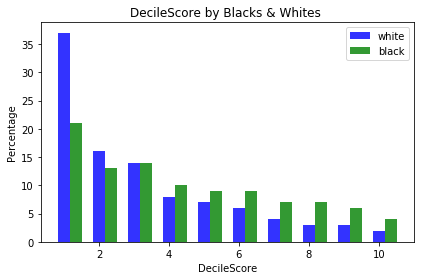

In [17]:
# Comparing White & Black defendants on the  'DecileScore'
grp_plot_compare(white, black, 'DecileScore','Ethnic_Code_Text', len(df), 100, \
                 'DecileScore by Blacks & Whites ', \
                 'white','black')

In [ ]:
# Whites have lower Decile Scores and Blacks have higher Decile Scores

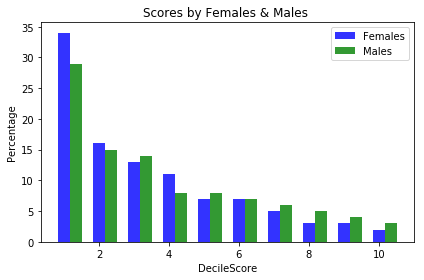

In [18]:
# Comparing Male & Female defendants on the  'DecileScore'
grp_plot_compare(female, male, 'DecileScore','Sex_Code_Text', len(df), 100, \
                 'Scores by Females & Males ', \
                 'Females','Males')


In [ ]:
# Females have lower Decile Scores and Males have higher Decile Scores

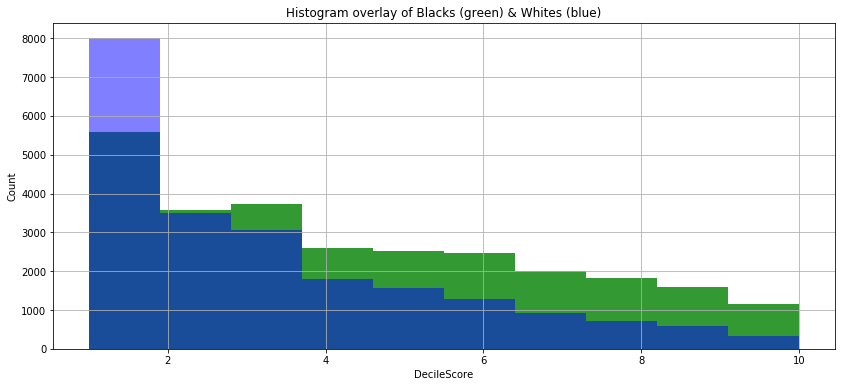

In [19]:
####################################################################################
# Histogram overlay
fig, ax = plt.subplots()
black['DecileScore'].hist(bins=10, figsize=[14,6],color='g',alpha=.8 )
white['DecileScore'].hist(bins=10, figsize=[14,6],color='b',alpha=.5 )
plt.title('Histogram overlay of Blacks (green) & Whites (blue)')
plt.legend()
plt.xlabel('DecileScore')
plt.ylabel('Count')
plt.show()
plt.clf()

# Feature Engineering

In [20]:
# Add column 'Age' from DateofBirth
agelist = []
currdate = date.today()
for dte in df['DateOfBirth']:
    brthdte = datetime.strptime(dte, '%m/%d/%y')
    mnthday = (currdate.month, currdate.day) < (brthdte.month, brthdte.day)
    if currdate.year > brthdte.year:
        agelist.append(currdate.year - brthdte.year - (mnthday))
    else:
        agelist.append(-1)
        

In [21]:
print(len(agelist), len(df))
df['Age'] = agelist
print(df.columns)

60798 60798
Index(['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName',
       'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text',
       'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
       'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
       'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType', 'IsCompleted', 'IsDeleted', 'Age'],
      dtype='object')


In [22]:
# cleanup bad Ages
# remove DecileScore < 1
(df['Age'] < 1).sum()

12782

In [23]:
df = df[df.Age >= 1]
(df['Age'] < 1).sum()

0

In [24]:
df['Age'].describe()

count    48016.000000
mean        33.030323
std          7.185404
min         20.000000
25%         27.000000
50%         32.000000
75%         38.000000
max         49.000000
Name: Age, dtype: float64

In [33]:
# Slice by 'DisplayText' for Risk
RiskAppear = df.loc[df['DisplayText'] == 'Risk of Failure to Appear']
RiskViolence = df.loc[df['DisplayText'] == 'Risk of Violence']
RiskRecidivism = df.loc[df['DisplayText'] == 'Risk of Recidivism']
print('Appear:', RiskAppear.shape, ' Violence: ', RiskViolence.shape,  ' Recidivism:',RiskRecidivism.shape)

Appear: (16016, 29)  Violence:  (16010, 29)  Recidivism: (15990, 29)


In [ ]:
# More feature engineering using Label encoder and One-Hot encoder

# Running ML models

# Train, Evaluate, and Select a Model

In [35]:
# Define prepare_data_for_ml_model_1:
def prepare_data_for_ml_model_1(dfx, target_loc):
    # Create new Dataset of selected columns to get prepare TEST and Training data for  ML model 
     
    """
    Columns
    0 - 4  : 'Person_ID','AssessmentID','Case_ID','Agency_Text', 'LastName',
    5 - 9  : 'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text','DateOfBirth',
    10 - 14: 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason','Language', 'LegalStatus',
    15 - 19: 'CustodyStatus', 'MaritalStatus','Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
    20 - 24: 'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
    25 - 28: 'AssessmentType', 'IsCompleted', 'IsDeleted','Age'
    """

    x_df = dfx.iloc[:, [7,8,14,15,16,19]] #features
    tmp_age = dfx.iloc[:,28].as_matrix() #age feature, convert numpy array
    x_age = tmp_age.reshape(tmp_age.size,1)
    

    y = dfx.iloc[:,target_loc].as_matrix() #target convert numpy array


    #  lable encoder. It encodes the data into integers
    le = LabelEncoder()

    Sex_Code_Text_cat = le.fit_transform(x_df.Sex_Code_Text)
    Ethnic_Code_Text_cat = le.fit_transform(x_df.Ethnic_Code_Text)
    LegalStatus_cat = le.fit_transform(x_df.LegalStatus)
    CustodyStatus_cat = le.fit_transform(x_df.CustodyStatus)
    MaritalStatus_cat = le.fit_transform(x_df.MaritalStatus)
    RecSupervisionLevelText_cat = le.fit_transform(x_df.RecSupervisionLevelText)

    Sex_Code_Text_cat = Sex_Code_Text_cat.reshape(len(Sex_Code_Text_cat),1)
    Ethnic_Code_Text_cat = Ethnic_Code_Text_cat.reshape(len(Ethnic_Code_Text_cat),1)
    LegalStatus_cat = LegalStatus_cat.reshape(len(LegalStatus_cat),1)
    CustodyStatus_cat = CustodyStatus_cat.reshape(len(CustodyStatus_cat),1)
    MaritalStatus_cat = MaritalStatus_cat.reshape(len(MaritalStatus_cat),1)
    RecSupervisionLevelText_cat = RecSupervisionLevelText_cat.reshape(len(RecSupervisionLevelText_cat),1)

#  One-Hot encoder. It encodes the data into binary format
    onehote = OneHotEncoder(sparse=False)
    
    Sex_Code_Text_oh = onehote.fit_transform(Sex_Code_Text_cat)
    Ethnic_Code_Text_oh = onehote.fit_transform(Ethnic_Code_Text_cat)
    LegalStatus_oh = onehote.fit_transform(LegalStatus_cat)
    CustodyStatus_oh = onehote.fit_transform(CustodyStatus_cat)
    MaritalStatus_oh = onehote.fit_transform(MaritalStatus_cat)
    RecSupervisionLevelText_oh = onehote.fit_transform(RecSupervisionLevelText_cat)

# Build out feature dataset as numpy array, since One-Hot encoder creates numpy array
    X_feature =  Sex_Code_Text_oh
    X_feature = np.concatenate((X_feature,Ethnic_Code_Text_oh), axis=1)
    X_feature = np.concatenate((X_feature,LegalStatus_oh), axis=1)
    X_feature = np.concatenate((X_feature,CustodyStatus_oh), axis=1)
    X_feature = np.concatenate((X_feature,MaritalStatus_oh), axis=1)
    X_feature = np.concatenate((X_feature,RecSupervisionLevelText_oh), axis=1)
    X_feature = np.concatenate((X_feature,x_age), axis=1)

# Split data train and test
    X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.2)
    print('Length for X_train:', len(X_train), ' X_test:',len(X_test), ' y_train:',len(y_train) ,' y_test:',len(y_test))

    return X_train, X_test, y_train, y_test

In [48]:
# Define ml_model_1:
# takes in model Instantiate model (model)
# fits, predicts, and evaluates (prints results)
def ml_model_1(model, modelnm, dfnm, X_train, X_test, y_train, y_test, target):
    print('Running ', modelnm, ' model for :', dfnm, ' using target: ', target)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Evaluate
    print(modelnm,' score: ',model.score(X_test, y_test))
    print(' ')
    print('first 10 predicted values: ',y_pred[0:10])
    print('first 10 values of target: ')
    print(y_test[0:10])
    print(' ')

    print('mean of predicted of values: ',np.mean(y_pred), ' STD of predicted of values : ', np.std(y_pred) )
    print('describe of target')
    print('mean of predicted of values: ',np.mean(y_test), ' STD of predicted of values : ', np.std(y_test) )

    return y_pred

In [ ]:
# MLPRegressor

In [49]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(alpha=0.001, hidden_layer_sizes = (10,), max_iter = 50000, 
                 activation = 'logistic', verbose = 'True', learning_rate = 'adaptive')

In [50]:
# MLPRegressor - RiskViolence dataset target RawScore (22)
# Preparing the data
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskViolence,22)

Length for X_train: 12808  X_test: 3202  y_train: 12808  y_test: 3202


In [51]:
# Predicting and getting score
ml_model_1(clf, 'MLPRegressor', 'RiskViolence', X_train, X_test, y_train, y_test, 'RawScore')

Running  MLPRegressor  model for : RiskViolence  using target:  RawScore
Iteration 1, loss = 2.08621372
Iteration 2, loss = 0.64900681
Iteration 3, loss = 0.27194653
Iteration 4, loss = 0.25274068
Iteration 5, loss = 0.23733573
Iteration 6, loss = 0.21079300
Iteration 7, loss = 0.18292073
Iteration 8, loss = 0.15713627
Iteration 9, loss = 0.13478836
Iteration 10, loss = 0.11700994
Iteration 11, loss = 0.10356468
Iteration 12, loss = 0.09361889
Iteration 13, loss = 0.08642701
Iteration 14, loss = 0.08121584
Iteration 15, loss = 0.07720991
Iteration 16, loss = 0.07445236
Iteration 17, loss = 0.07229519
Iteration 18, loss = 0.07065360
Iteration 19, loss = 0.06933459
Iteration 20, loss = 0.06840406
Iteration 21, loss = 0.06749435
Iteration 22, loss = 0.06676693
Iteration 23, loss = 0.06617134
Iteration 24, loss = 0.06573268
Iteration 25, loss = 0.06523605
Iteration 26, loss = 0.06497891
Iteration 27, loss = 0.06449973
Iteration 28, loss = 0.06425165
Iteration 29, loss = 0.06375961
Iteratio

array([-2.28008133, -2.39941825, -1.75093232, ..., -2.18279423,
       -3.38399673, -1.36211774])

In [ ]:
# Running  MLPRegressor  model for : RiskViolence  using target:  RawScore
#  score:  0.7991285969829444

In [52]:
# MLPRegressor - RiskRecidivism dataset target RawScore (22)
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskRecidivism,22)

Length for X_train: 12792  X_test: 3198  y_train: 12792  y_test: 3198


In [53]:
# Predicting and getting score
ml_model_1(clf, 'MLPRegressor', 'RiskRecidivism', X_train, X_test, y_train, y_test, 'RawScore')

Running  MLPRegressor  model for : RiskRecidivism  using target:  RawScore
Iteration 1, loss = 0.26672495
Iteration 2, loss = 0.21064967
Iteration 3, loss = 0.16216172
Iteration 4, loss = 0.13225670
Iteration 5, loss = 0.11163707
Iteration 6, loss = 0.09636202
Iteration 7, loss = 0.08435888
Iteration 8, loss = 0.07454403
Iteration 9, loss = 0.06963847
Iteration 10, loss = 0.06754194
Iteration 11, loss = 0.06649270
Iteration 12, loss = 0.06583040
Iteration 13, loss = 0.06556066
Iteration 14, loss = 0.06555123
Iteration 15, loss = 0.06524557
Iteration 16, loss = 0.06514484
Iteration 17, loss = 0.06510033
Iteration 18, loss = 0.06553975
Iteration 19, loss = 0.06491469
Iteration 20, loss = 0.06498886
Iteration 21, loss = 0.06468869
Iteration 22, loss = 0.06465106
Iteration 23, loss = 0.06450404
Iteration 24, loss = 0.06462371
Iteration 25, loss = 0.06470707
Iteration 26, loss = 0.06456066
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
MLPRegresso

array([-1.04940271, -0.71585198, -1.32141611, ..., -0.10569741,
       -1.01694912,  0.41985795])

In [ ]:
# MLPRegressor  model for : RiskRecidivism  using target:  RawScore
#  score:  0.7623471847337094

In [55]:
# MLPRegressor - RiskViolence dataset target DecileScore (23)
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskViolence,23)
ml_model_1(clf, 'MLPRegressor','RiskViolence', X_train, X_test, y_train, y_test, 'DecileScore')

Length for X_train: 12808  X_test: 3202  y_train: 12808  y_test: 3202
Running  MLPRegressor  model for : RiskViolence  using target:  DecileScore
Iteration 1, loss = 7.20353259
Iteration 2, loss = 5.22078987
Iteration 3, loss = 4.02220266
Iteration 4, loss = 3.55016279
Iteration 5, loss = 3.30301570
Iteration 6, loss = 3.17578622
Iteration 7, loss = 3.11325690
Iteration 8, loss = 3.08440802
Iteration 9, loss = 3.07075305
Iteration 10, loss = 3.06546669
Iteration 11, loss = 3.06267385
Iteration 12, loss = 3.06084106
Iteration 13, loss = 3.05951934
Iteration 14, loss = 3.05827900
Iteration 15, loss = 3.05655018
Iteration 16, loss = 3.05413697
Iteration 17, loss = 3.04721674
Iteration 18, loss = 2.90081035
Iteration 19, loss = 2.65998526
Iteration 20, loss = 2.53197800
Iteration 21, loss = 2.41706377
Iteration 22, loss = 2.30460678
Iteration 23, loss = 2.19467593
Iteration 24, loss = 2.08681178
Iteration 25, loss = 1.98589664
Iteration 26, loss = 1.89191376
Iteration 27, loss = 1.80426559

array([4.9227644 , 4.63290985, 4.8743944 , ..., 8.96950544, 2.64896815,
       3.99204643])

In [ ]:
# Running  MLPRegressor  model for : RiskViolence  using target:  DecileScore
# score 0.8189767335097896

In [56]:
# MLPRegressor - RiskRecidivism dataset target DecileScore (23)
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskRecidivism,23)
# Predicting and getting score
y_pred_MLPR = ml_model_1(clf, 'MLPRegressor', 'RiskRecidivism', X_train, X_test, y_train, y_test, 'DecileScore')


Length for X_train: 12792  X_test: 3198  y_train: 12792  y_test: 3198
Running  MLPRegressor  model for : RiskRecidivism  using target:  DecileScore
Iteration 1, loss = 12.85544492
Iteration 2, loss = 8.25033617
Iteration 3, loss = 5.66191719
Iteration 4, loss = 4.89177071
Iteration 5, loss = 4.47713028
Iteration 6, loss = 4.22695786
Iteration 7, loss = 4.07597966
Iteration 8, loss = 3.98806505
Iteration 9, loss = 3.93889828
Iteration 10, loss = 3.91195802
Iteration 11, loss = 3.89766728
Iteration 12, loss = 3.89018947
Iteration 13, loss = 3.88548218
Iteration 14, loss = 3.88189357
Iteration 15, loss = 3.87719125
Iteration 16, loss = 3.86560696
Iteration 17, loss = 3.75481872
Iteration 18, loss = 3.50736904
Iteration 19, loss = 3.38205811
Iteration 20, loss = 3.28916306
Iteration 21, loss = 3.21116204
Iteration 22, loss = 3.13937530
Iteration 23, loss = 3.06440399
Iteration 24, loss = 2.83423427
Iteration 25, loss = 2.68104704
Iteration 26, loss = 2.36365840
Iteration 27, loss = 2.09345

In [ ]:
# Running  MLPRegressor  model for : RiskRecidivism  using target:  DecileScore
# score:  0.839306183826078

In [57]:
# LinearRegression
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()

In [58]:
# LinearRegression - RiskRecidivism dataset target RawScore (22)
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskRecidivism,22)
# Predicting and getting score
ml_model_1(lr1, 'Linear', 'RiskRecidivism', X_train, X_test, y_train, y_test, 'RawScore')

Length for X_train: 12792  X_test: 3198  y_train: 12792  y_test: 3198
Running  Linear  model for : RiskRecidivism  using target:  RawScore
Linear  score:  0.7671065492720913
 
first 10 predicted values:  [ 0.29931641 -0.15527344  0.43212891 -1.10009766 -1.13867188 -0.76123047
 -1.01757812 -1.01464844 -1.07421875 -0.88818359]
first 10 values of target: 
[ 0.64 -0.16  0.75 -0.65 -1.6  -0.62 -1.28 -1.35 -0.64 -0.34]
 
mean of predicted of values:  -0.5789477340574187  STD of predicted of values :  0.6510778969239339
describe of target
mean of predicted of values:  -0.5834146341463415  STD of predicted of values :  0.7484217106495393


array([ 0.29931641, -0.15527344,  0.43212891, ..., -0.95214844,
       -0.26171875,  0.3815918 ])

In [ ]:
# Running  Linear  model for : RiskRecidivism  using target:  RawScore
# score:  0.7671065492720913

In [59]:
# LinearRegression - RiskRecidivism dataset target DecileScore (23)
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskRecidivism,23)
# Predicting and getting score
ml_model_1(lr1, 'Linear', 'RiskRecidivism', X_train, X_test, y_train, y_test, 'DecileScore')

Length for X_train: 12792  X_test: 3198  y_train: 12792  y_test: 3198
Running  Linear  model for : RiskRecidivism  using target:  DecileScore
Linear  score:  0.827406348277057
 
first 10 predicted values:  [9.23974609 6.72851562 3.24316406 8.10107422 2.81445312 2.87402344
 8.55810547 3.25634766 8.3671875  2.75488281]
first 10 values of target: 
[9 6 2 9 5 2 5 2 8 2]
 
mean of predicted of values:  4.776425359844043  STD of predicted of values :  2.5360231481670517
describe of target
mean of predicted of values:  4.749218261413383  STD of predicted of values :  2.801370669026598


array([9.23974609, 6.72851562, 3.24316406, ..., 2.07568359, 2.83398438,
       2.84667969])

In [60]:
# Running  Linear  model for : RiskRecidivism  using target:  DecileScore
# score:  0.827406348277057

In [61]:
# RandomForestRegressor
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [62]:
# RandomForestRegressor - RiskRecidivism dataset target DecileScore (23)
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskRecidivism,23)
ml_model_1(rf, 'RandomForestRegressor', 'RiskRecidivism', X_train, X_test, y_train, y_test, 'DecileScore')


Length for X_train: 12792  X_test: 3198  y_train: 12792  y_test: 3198
Running  RandomForestRegressor  model for : RiskRecidivism  using target:  DecileScore
RandomForestRegressor  score:  0.8267277428935579
 
first 10 predicted values:  [8.65465489 3.09882811 6.23816017 1.32383426 2.63270437 3.63569604
 8.46940511 3.56385477 1.32363285 8.16574185]
first 10 values of target: 
[10  2  4  5  2  4  9  5  1  9]
 
mean of predicted of values:  4.790910426835234  STD of predicted of values :  2.584506865208442
describe of target
mean of predicted of values:  4.7636022514071295  STD of predicted of values :  2.7671396234116186


array([8.65465489, 3.09882811, 6.23816017, ..., 6.45114081, 2.40050517,
       2.08397577])

In [ ]:
# Running  RandomForestRegressor  model for : RiskRecidivism  using target:  DecileScore
# score:  0.8267277428935579

In [63]:
# RandomForestRegressor - RiskRecidivism dataset target RawScore (22)
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskRecidivism,22)
ml_model_1(rf, 'RandomForestRegressor', 'RiskRecidivism', X_train, X_test, y_train, y_test, 'RawScore')

Length for X_train: 12792  X_test: 3198  y_train: 12792  y_test: 3198
Running  RandomForestRegressor  model for : RiskRecidivism  using target:  RawScore
RandomForestRegressor  score:  0.7659148065359824
 
first 10 predicted values:  [-1.42196634 -1.21726591 -0.96996057 -1.69437275 -1.09818838 -1.083798
 -1.44916898  0.69718419 -1.39898619 -1.37823091]
first 10 values of target: 
[-2.22 -1.51 -1.02 -0.67 -1.3  -1.42 -1.69  0.95 -1.97 -1.96]
 
mean of predicted of values:  -0.5766601315079414  STD of predicted of values :  0.6734249541578053
describe of target
mean of predicted of values:  -0.5864634146341463  STD of predicted of values :  0.740559914691666


array([-1.42196634, -1.21726591, -0.96996057, ..., -0.95669646,
        0.20727962, -1.22911306])

In [ ]:
# Running  RandomForestRegressor  model for : RiskRecidivism  using target:  RawScore
# score:  0.7659148065359824

In [64]:
# Gaussian Naive Bayes Classifier
# 
from sklearn.naive_bayes import GaussianNB
Gclf = GaussianNB()


In [65]:
# GaussianNB - RiskRecidivism dataset target DecileScore (23)
X_train, X_test, y_train, y_test = prepare_data_for_ml_model_1(RiskRecidivism,23)
ml_model_1(Gclf,'GaussianNB', 'RiskRecidivism', X_train, X_test, y_train, y_test, 'DecileScore')


Length for X_train: 12792  X_test: 3198  y_train: 12792  y_test: 3198
Running  GaussianNB  model for : RiskRecidivism  using target:  DecileScore
GaussianNB  score:  0.2858036272670419
 
first 10 predicted values:  [1 1 1 8 1 1 1 6 1 7]
first 10 values of target: 
[ 2  4  2 10  5  3  1  7  2  6]
 
mean of predicted of values:  3.7432770481550968  STD of predicted of values :  3.1822006565117373
describe of target
mean of predicted of values:  4.774859287054409  STD of predicted of values :  2.780139218345568


array([1, 1, 1, ..., 8, 8, 1], dtype=int64)

In [ ]:
# Running  GaussianNB  model for : RiskRecidivism  using target:  DecileScore
# score:  0.2858036272670419

# Best score for Model MLPRegressor
Running  MLPRegressor  model for : RiskRecidivism  using target:  DecileScore
 score:  0.839306183826078